[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/https://github.com/Shuhrat-git/ML_assignment_2.git/blob/main/aquifer_time.ipynb)


1. Data loading

In [14]:
import pandas as pd
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset from the URL
url = "https://raw.githubusercontent.com/isa-ulisboa/greends-pml/main/data/aquifer_time_series.csv"
df = pd.read_csv(url, dayfirst=True, parse_dates=['date'])

# Display the first few rows to inspect the data, the overall structure and missing values
print(df.head())
print(df.info())
print(df.isnull().sum())

        date  rainfall_mm  depth_to_groundwater_m  temperature_C  drainage_m3  \
0 2006-03-14          NaN                  -22.18            NaN          NaN   
1 2006-03-15          NaN                  -22.14            NaN          NaN   
2 2006-03-16          NaN                  -22.04            NaN          NaN   
3 2006-03-17          NaN                  -22.04            NaN          NaN   
4 2006-03-18          NaN                  -22.04            NaN          NaN   

   river_hydrometry_m  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    5223 non-null   datetime64[ns]
 1   rainfall_mm             4199 non-null   float64       
 2   depth_to_groundwat

2. Interpolation of missing values

In [15]:
# Set 'date' as index to prepare for time-based interpolation
df.set_index('date', inplace=True)

# Perform time-based interpolation to fill missing values
df.interpolate(method='time', inplace=True)

# Reset the index to bring 'date' back as a column
df.reset_index(inplace=True)

# Check again for any missing values
print(df.isnull().sum())


date                         0
rainfall_mm               1024
depth_to_groundwater_m       0
temperature_C             1024
drainage_m3                197
river_hydrometry_m        1024
dtype: int64


3. Aggregation by month

In [16]:
# Create a new column representing the year and month
df['year_month'] = df['date'].dt.to_period('M')

# Aggregate the data by month using the median
monthly_df = df.groupby('year_month').median().reset_index()

# Convert 'year_month' back to timestamp for easier handling
monthly_df['year_month'] = monthly_df['year_month'].dt.to_timestamp()

# Display the first few rows of the monthly aggregated data
print(monthly_df.head())

  year_month                date  rainfall_mm  depth_to_groundwater_m  \
0 2006-03-01 2006-03-22 12:00:00          NaN                 -21.890   
1 2006-04-01 2006-04-15 12:00:00          NaN                 -21.585   
2 2006-05-01 2006-05-16 00:00:00          NaN                 -21.610   
3 2006-06-01 2006-06-15 12:00:00          NaN                 -22.080   
4 2006-07-01 2006-07-16 00:00:00          NaN                 -23.430   

   temperature_C  drainage_m3  river_hydrometry_m  
0            NaN          NaN                 NaN  
1            NaN          NaN                 NaN  
2            NaN          NaN                 NaN  
3            NaN          NaN                 NaN  
4            NaN          NaN                 NaN  


4. Creating lagging features

In [17]:
def create_lag_features(df, target_col, lags=12):
    """
    Create lagged features for each attribute except the target variable.
    Target will be the current month's target value.
    """
    df_lagged = df.copy()
    feature_cols = df.columns.drop(['year_month', target_col])
    
    for col in feature_cols:
        for lag in range(0, lags + 1):
            df_lagged[f'{col}_lag{lag}'] = df_lagged[col].shift(lag)
    
    # Set the target variable
    df_lagged['target'] = df_lagged[target_col]
    
    # Drop rows with missing values caused by shifting
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    
    return df_lagged


In [18]:
# Apply the function to create the lagged dataset
dataset = create_lag_features(monthly_df, target_col='depth_to_groundwater_m', lags=12)

# Display the first few rows
print(dataset.head())
print(dataset.shape)

  year_month                date  rainfall_mm  depth_to_groundwater_m  \
0 2010-01-01 2010-01-16 00:00:00          0.0                 -28.900   
1 2010-02-01 2010-02-14 12:00:00          0.0                 -28.245   
2 2010-03-01 2010-03-16 00:00:00          0.0                 -27.270   
3 2010-04-01 2010-04-15 12:00:00          0.0                 -26.155   
4 2010-05-01 2010-05-16 00:00:00          0.0                 -25.530   

   temperature_C  drainage_m3  river_hydrometry_m           date_lag0  \
0           3.70   -27298.944                 2.6 2010-01-16 00:00:00   
1           6.45   -28416.960                 2.7 2010-02-14 12:00:00   
2           8.50   -29649.888                 2.6 2010-03-16 00:00:00   
3          12.20   -29194.560                 2.4 2010-04-15 12:00:00   
4          16.30   -28631.232                 2.4 2010-05-16 00:00:00   

            date_lag1           date_lag2  ... river_hydrometry_m_lag4  \
0 2009-12-16 00:00:00 2009-11-15 12:00:00  ...  

5. Feature preparation and model training

In [19]:
# Prepare features and target
X = dataset.drop(columns=['year_month', 'target'])

# Select only numeric columns (drop datetime columns accidentally shifted)
X = X.select_dtypes(include=[np.number])

y = dataset['target']

# Create groups based on the year
groups = dataset['year_month'].dt.year

# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Setup GroupKFold
gkf = GroupKFold(n_splits=5)

# Perform cross-validation
scores = cross_val_score(model, X, y, cv=gkf, groups=groups, scoring='r2')

# Print cross-validation scores
print(f"R2 scores for each fold: {scores}")
print(f"Mean R2 score: {np.mean(scores):.4f}")



R2 scores for each fold: [0.94215491 0.98891587 0.56962428 0.95753307 0.94444056]
Mean R2 score: 0.8805


6. Final model and plotting

Final R2 on full data: 0.9981
RMSE on full data: 0.1237


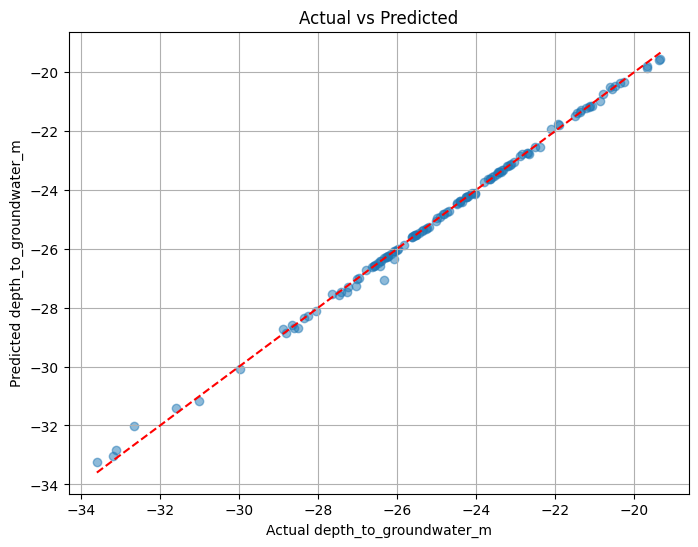

In [20]:
# Train the model on the entire dataset
model.fit(X, y)

# Predict on the same dataset
y_pred = model.predict(X)

# Evaluate performance
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f"Final R2 on full data: {r2_score(y, y_pred):.4f}")
print(f"RMSE on full data: {rmse:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual depth_to_groundwater_m')
plt.ylabel('Predicted depth_to_groundwater_m')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()